In [1]:
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
#@tf.function
def mσ(x):
    return tf.math.divide(1, 1 + tf.math.exp(tf.math.negative(x)))


#@tf.function
def mdσ(x):
    return mσ(x) * (1 - mσ(x))


#@tf.function
def md2σ(x):
    return mσ(x) * (1 - mσ(x)) * (1 - 2*mσ(x))

In [4]:
def tensor_hadamard(v,A):
    return [tf.reshape(i, (i.shape[0], 1)) * A for i in tf.unstack(v, axis = 1)]

In [5]:
def get_gradient_layer(W,b,a,grad):
    W = tf.cast(W, 'float64')
    b = tf.cast(b, 'float64')
    a = tf.cast(a, 'float64')
    grad = tf.cast(grad, 'float64')
    x = mdσ(tf.transpose(a @ W + b))
    return W @ (mdσ(tf.transpose(a @ W + b)) * grad)

In [6]:
#@tf.function
def get_gradient_hessian_last_layer(W,b,a,grad):
#     z = tf.transpose(a @ W + b)
#     return W @ (mdσ(z) * grad), W @ (md2σ(z) * tf.transpose(W))
    W = tf.cast(W, 'float64')
    b = tf.cast(b, 'float64')
    a = tf.cast(a, 'float64')
    grad = tf.cast(grad, 'float64')
    z = tf.transpose(a @ W + b)
    return W @ (mdσ(z) * grad), W @ tensor_hadamard(grad * md2σ(z),tf.transpose(W)), z

In [7]:
#@tf.function
def get_gradient_hessian_hidden_layer(W,b,a,grad,hess):
#     z = tf.transpose(a @ W + b)
#     dσt = mdσ(z) * tf.transpose(W)
#     return W @ (mdσ(z) * grad), W @ ((grad * md2σ(z)) * tf.transpose(W)) + tf.transpose(dσt) @ hess @ dσt
    W = tf.cast(W, 'float64')
    b = tf.cast(b, 'float64')
    a = tf.cast(a, 'float64')
    grad = tf.cast(grad, 'float64')
    hess = tf.cast(hess, 'float64')
    z = tf.transpose(a @ W + b)
    WT = tf.transpose(W)
    mdσz = mdσ(z)
    dσt = tensor_hadamard(mdσz, WT)
    dσtT = tf.transpose(dσt, perm=[0, 2, 1])
    t2 = tensor_hadamard(grad * md2σ(z), WT)
    return W @ (mdσz * grad), W @ t2 + dσtT @ hess @ dσt 

In [8]:
#DTYPE = 'float32'
DTYPE = 'float64'
adj = 5
tf.keras.backend.set_floatx(DTYPE)
time_dependent = False

# Specify adjacency matrix
if adj == 1:
    A = tf.constant([[0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0]
                ], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 1.
    xmin = 0.
    xmax = 0.1
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 7])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.0])
    dirichletBeta = np.array([0.0, 0.5])
                              
    
    eps = 0.01
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)

    
elif adj == 2:
    A = tf.constant([[0, 1],
                 [0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 1])
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
        #return .5 +(.5*-tf.sin(x*np.pi))
    
elif adj == 3:
    A = tf.constant([[0, 1, 0],
                     [0, 0, 1],
                     [0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 0.5
    
    eps = .01

    dirichletNodes = np.array([0, 2])
    
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    #time_dependent = True
    #dirichletAlpha = np.array([lambda x: 0.7*x/10, lambda x: 0.0*x])
    #dirichletBeta = np.array([lambda x: 0.0, lambda x: 0.8*x/10])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 4:
    A = tf.constant([[0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 2, 3])
    dirichletAlpha = np.array([0.7, 0.0, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.0])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 0:
    A = tf.constant([[0, 0, 1,0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1],
                 [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 4.
    xmin = 0.
    xmax = 1.
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 1, 3])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.8, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.])
                              
    
    eps = 1e-6
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
elif adj == 5:
    A = tf.constant([[0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 1],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    dirichletNodes = np.array([0, 1, 4, 5])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.9, 0.3, 0., 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.8, 0.1])
                              
    eps = 1e-2
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.


# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)

# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)


ne = 0 

for i in range(A.shape[0]):
    for j in range(i + 1, A.shape[0]):
        if A[i, j] > 0:
            ne = ne + 1



In [9]:
print(ne)

5


In [10]:
# Define model architecture
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb = lb, ub = ub,
                 output_dim=ne,
                 num_hidden_layers=2,
                 num_neurons_per_layer=20,
                 use_activation = True,
                 activation='sigmoid',
                 use_activation_output = True,
                 activation_output='sigmoid',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Inititialize num_hidden_layers many fully connected dense layers
        if use_activation is True:
            self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        else:
            self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=None,
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        #self.out = tf.keras.layers.Dense(output_dim, activation=None)
        if use_activation_output is True:
            self.out = tf.keras.layers.Dense(output_dim, activation=activation_output)
        else:
            self.out = tf.keras.layers.Dense(output_dim, activation=None)
        
    def call(self, X):
        """Forward-pass through neural network."""
        self.tmp_layer_output = []
        #Z = self.scale(X)
        Z = X
        self.tmp_layer_output.append(Z)
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            self.tmp_layer_output.append(Z)
            
        return self.out(Z)
    

    def get_gradient(self, x):
        x = tf.reshape(x, (1,2))
        output = self.call(x)
        grad = get_gradient_layer(self.out.weights[0], self.out.weights[1], self.tmp_layer_output[-1], np.identity(self.output_dim))

        for k in range(self.num_hidden_layers-1, -1, -1):
            grad = get_gradient_layer(self.hidden[k].weights[0], self.hidden[k].weights[1], self.tmp_layer_output[k], grad)

        return output, grad
    

    def get_gradient_and_hessian(self, x):
        output = self.call(tf.reshape(x, (1,2)))
        grad,hess,z = get_gradient_hessian_last_layer(self.out.weights[0], self.out.weights[1], self.tmp_layer_output[-1], np.identity(self.output_dim))

        for k in range(self.num_hidden_layers-1, -1, -1):
            grad,hess = get_gradient_hessian_hidden_layer(self.hidden[k].weights[0], self.hidden[k].weights[1], self.tmp_layer_output[k], grad,  hess)

        return output, grad, hess

In [29]:
NN = PINN(num_hidden_layers=3,
                 num_neurons_per_layer=20,
                 activation='tanh')

In [30]:
import networkx as nx

class GraphPINN():
    
    def __init__(self, 
                 inp = A, 
                 dirichletNodes = dirichletNodes, 
                 dirichletAlpha = dirichletAlpha, 
                 dirichletBeta = dirichletBeta, 
                 lb = lb, ub = ub, model = NN):
        
        if isinstance(inp, nx.classes.multidigraph.MultiGraph):
            self.G = inp
            self.A = nx.adjacency_matrix(G).toarray()
            
        elif tf.is_tensor(A) and len(A.shape)==2:
            # Store adjacency matrix
            self.A = A
            # Define networkx multigraph
            self.G = nx.MultiDiGraph(A.numpy())
            
        else:
            raise ValueError('Check input type of GraphPINN.')
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Setup list of neural networks
        self.NNs = model
        
        # Determine graph layout if necessary
        self.pos = nx.kamada_kawai_layout(self.G)
        
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij.numpy())

        # Get number of edges
        self.ne = len(self.E)
        
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
        
    
    def plotGraph(self, **kwargs):

        nx.draw(self.G, pos=self.pos, with_labels=True, **kwargs)
    
    

Vin: [[], [], [0, 1], [2], [3], [4]]
Vout: [[0], [1], [2], [3, 4], [], []]


{0: array([0.61338534, 0.935451  ]),
 1: array([0.500243, 1.      ]),
 2: array([0.18949096, 0.32161507]),
 3: array([-0.18377935, -0.32492122]),
 4: array([-0.61590406, -0.93321776]),
 5: array([-0.5034359 , -0.99892709])}

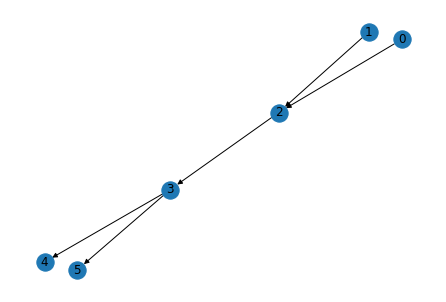

In [31]:
%matplotlib inline

gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub)
gPINN.plotGraph()
print('Vin:', gPINN.Vin)
print('Vout:', gPINN.Vout)
gPINN.E
gPINN.pos

In [32]:
mode = 'deterministic'
mode = 'uniform'

N_0 = 1000
N_b = 1000
N_r = 4000

# Set random seed for reproducible results
tf.random.set_seed(0)

def drawCollocationPoints(N_0, N_b, N_r):
    X_r = tf.random.uniform((N_r,2), lb, ub, dtype=DTYPE)
    
    # Draw uniform sample points for initial boundary data
    t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
    x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
    X_0 = tf.concat([t_0, x_0], axis=1)
    
    # Boundary data
    t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
    x_l = tf.ones((N_b,1), dtype=DTYPE) * lb[1]
    X_l = tf.concat([t_b, x_l], axis=1)
    
    x_u = tf.ones((N_b,1), dtype=DTYPE) * ub[1]
    X_u = tf.concat([t_b, x_u], axis=1)
    
    X_b = tf.concat([X_l, X_u], axis=0)

    # Draw uniformly sampled collocation points
    t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
    x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)
    # X_data = tf.concat([X_0, X_b, X_r], axis=0)
    return X_r, X_0, X_l, X_u

if mode == 'deterministic':

    # Uniform distributed collocation points
    t_r = tf.linspace(lb[0], ub[0], N_0+1)
    x_r = tf.linspace(lb[1], ub[1], N_b+1)
    tt, xx = tf.meshgrid(t_r,x_r)
    X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)

elif mode == 'uniform':
    
    X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #X_data = tf.concat([X_0, X_b, X_r], axis=0)

Text(0, 0.5, 'x')

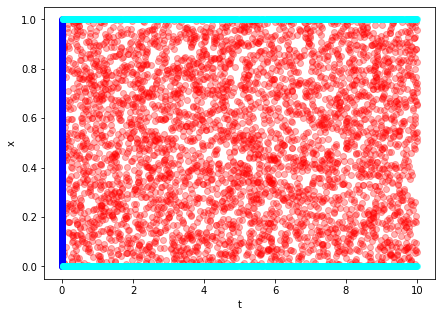

In [33]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0].numpy(), X_r[:,1].numpy(),color='red',alpha=0.3)
ax.scatter(X_0[:,0].numpy(), X_0[:,1].numpy(), color='blue', alpha=0.5)
ax.scatter(X_u[:,0].numpy(), X_u[:,1].numpy(), color='cyan', alpha=0.5)
ax.scatter(X_l[:,0].numpy(), X_l[:,1].numpy(), color='cyan', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel('x')

In [34]:
from time import time

class graphPINNSolver(object):
    def __init__(self, graphPINN):
        
        self.graphPINN = graphPINN
        self.ne = self.graphPINN.ne
        
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        self.graphPINN.NNs(tf.constant([[1., 1.]], dtype=DTYPE))
        self.trainable_variables.append(self.graphPINN.NNs.trainable_variables)
        
#         self.graphPINN.NNs(tf.constant([[1., 1.]], dtype=DTYPE))
#         self.trainable_variables = self.graphPINN.NNs.trainable_variables
        
        # Setup auxiliary variables for vertex values to ensure continuity
        self._setupVertexVariables()
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            self.trainable_variables.append([self.vertexVals[i]])
        
        self.nvar = len(self.trainable_variables)
        
    def _updateData(self, Xr, X0, Xl, Xu):
        self.Xr = Xr
        self.X0 = X0
        self.Xl = Xl
        self.Xu = Xu
        self.nr = Xr.shape[0]
        self.n0 = X0.shape[0]
        self.nb = Xl.shape[0]
    
    def decompose_data(self, X, N_0 = 1000, N_b = 1000, N_r = 4000):
        self.Xr = tf.convert_to_tensor(X[:N_r, :])
        self.X0 = tf.convert_to_tensor(X[N_r:(N_r+N_0), :])
        self.Xl = tf.convert_to_tensor(X[(N_r+N_0):(N_r+N_0+N_b), :])
        self.Xu = tf.convert_to_tensor(X[(N_r+N_0+N_b):, :])
        self.nr = N_r
        self.n0 = N_0
        self.nb = N_b
        

    def _setupVertexVariables(self):
        
        self.vertexVals = []
        for _ in self.graphPINN.innerVertices:
            self.vertexVals.append(tf.Variable(tf.random.uniform(shape=(1000,), dtype=DTYPE), trainable=True))

    def _fvals0(self, tx):

        return self.graphPINN.NNs(tx)
    
    
    def _fvals1(self, tx):
        
        # Initialize lists for values and derivatives
        
        output, gradient = tf.vectorized_map(self.graphPINN.NNs.get_gradient, tx)
        u = tf.reshape(output, (output.shape[0], self.ne))
        ut = tf.concat([tf.reshape(gradient[:,0,i], (tx.shape[0], 1)) for i in range(self.ne)], axis = 1)
        ux = tf.concat([tf.reshape(gradient[:,1,i], (tx.shape[0], 1)) for i in range(self.ne)], axis = 1)
                            
        return u, ut, ux
    
    
    def _fvals2(self, tx):
        
        output, gradient, hess = tf.vectorized_map(self.graphPINN.NNs.get_gradient_and_hessian, tx)
        u = tf.reshape(output, (output.shape[0], self.ne))
        ut = tf.concat([tf.reshape(gradient[:,0,i], (tx.shape[0], 1)) for i in range(self.ne)], axis = 1)
        ux = tf.concat([tf.reshape(gradient[:,1,i], (tx.shape[0], 1)) for i in range(self.ne)], axis = 1)
                            
        return u, ut, ux, hess[:,:,0,0]

    
    
    def determine_losses(self):
        # Short-hand notation of mean-squared loss
        mse = lambda x : tf.reduce_mean(tf.square(x))
        
        ###################################
        ### Residual loss for all edges ###
        ###################################
        u, ut, ux, uxx = self._fvals2(self.Xr)
        
        loss_res = 0
        for i in range(self.ne):
            res_e = pde(u[:,i], ut[:,i], ux[:,i], uxx[:,i])
            loss_res += mse(res_e)
        
        
        ###################################
        ### Initial conds for all edges ###
        ###################################
        
        u = self._fvals0(self.X0)
        
        loss_init = 0
        for i in range(self.ne):
            res_e = u[:,i] - initial_cond(self.X0[:,1])
            loss_init += mse(res_e)
        
        ###################################
        ###   Continuity in vertices    ###
        ###################################
        
        ul, ult, ulx = self._fvals1(self.Xl)
        uu, uut, uux = self._fvals1(self.Xu)
        loss_cont = 0
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            
            for j in self.graphPINN.Vin[v]:
                val = uu[:,j] - self.vertexVals[i]
                loss_cont += mse(val)

            for j in self.graphPINN.Vout[v]:
                val = ul[:,j] - self.vertexVals[i]
                loss_cont += mse(val)

        #####################################
        ### Kirchhoff-Neumann in vertices ###
        #####################################
        
        # Kirchhoff-Neumann condition in center nodes
        loss_KN = 0
        for i in self.graphPINN.innerVertices:
            
            val = 0
            print('Kirchhoff-Neumann in node ', i)
            for j in self.graphPINN.Vin[i]:
                print('incoming edge:', j)
                val += flux(uu[:,j], uux[:,j])
                
            for j in self.graphPINN.Vout[i]:
                print('outgoing edge:', j)
                val -= flux(ul[:,j], ulx[:,j])
            loss_KN += mse(val)
        
        #####################################
        ###      Inflow/Outflow conds     ###
        #####################################
            
        loss_D = 0
        for i,v in enumerate(self.graphPINN.dirichletNodes):
            
            if time_dependent:
                alpha = self.graphPINN.dirichletAlpha[i](self.Xl[:,0])
                beta = self.graphPINN.dirichletBeta[i](self.Xl[:,0])
            else:
                alpha = self.graphPINN.dirichletAlpha[i]
                beta = self.graphPINN.dirichletBeta[i]
            
            print('\nin node ', v, 'alpha ', alpha, 'beta ', beta)
            val = 0
            for j in self.graphPINN.Vin[v]:
                print('outflow: ', j)
                val += flux(uu[:,j], uux[:,j]) \
                    - beta * (uu[:,j])
                #loss_D += mse(val)

            for j in self.graphPINN.Vout[v]:
                print('inflow: ', j)
                val += -flux(ul[:,j], ulx[:,j]) \
                    + alpha * (1-ul[:,j])
                #loss_D += mse(val)
            loss_D += mse(val)
        print(loss_res)
        print(loss_init)
        print(loss_cont)
        print(loss_KN)
        print(loss_D)
        return loss_res, loss_init, loss_cont, loss_KN, loss_D
    
    def loss_fn(self):
        
        loss_res, loss_init, loss_cont, loss_KN, loss_D = self.determine_losses()
        
        loss = loss_res + loss_init + loss_cont + loss_KN + loss_D

        return loss
    
    @tf.function
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.nvar):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            
    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list


        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0

            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        self.callback_init()

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
    
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None):
        if self.iter % 20 == 0:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [42]:
import keras_tuner as kt


class HyperRegressor(kt.HyperModel):
    def build(self, hp):

        return PINN(num_hidden_layers = hp.Int("num_layers", min_value=0, max_value=9, step=1), 
                    num_neurons_per_layer = hp.Int("num_neurons_per_layer", min_value=2, max_value=32, step=1),
                    use_activation = hp.Boolean("use_activation"),
                    activation = hp.Choice("activation", ["sigmoid", "tanh", "relu", "elu", "gelu", "hard_sigmoid", "linear", "selu", "softplus", "swish"]),
                    use_activation_output = hp.Boolean("use_activation_output"),
                    activation_output = hp.Choice("activation_output", ["sigmoid", "tanh", "relu", "elu", "gelu", "hard_sigmoid", "linear", "selu", "softplus", "swish"]))
    

    def fit(self, hp, model, x, y, validation_data, **kwargs):
        solver = graphPINNSolver(GraphPINN(model = model))
        solver.decompose_data(x)
        
        # ADAM 
        lr = 0.01
        optim = tf.keras.optimizers.Adam(learning_rate=lr)
        
        t_1 = time()
        
        solver.solve_with_TFoptimizer(optim, N=2001)
        
        timediff_1 = time()-t_1
        
        # Wir wollen nicht so lange warten
        if timediff_1 > 60:
            return 100
        
        # LBFGS
        t_2 = time()
        
        solver.solve_with_ScipyOptimizer(options={'maxiter': 5000, 'maxfun': 50000, 'maxcor': 50, 'maxls': 50, 'ftol': 1.0*np.finfo(float).eps})
        
        timediff_2 = time()-t_2
        
        
        loss = solver.loss_fn().numpy()
        
        timediff = timediff_1 + timediff_2
        
        # Vielleicht andere loss-funktion
        loss_complete = 0.5 * loss / 0.001 + 0.4 * timediff / 180 + 0.1 * solver.iter / 7000
        
        if loss > 0.001 or timediff > 180:
            return 5 * loss_complete
        else: 
            return loss_complete



#tuner = kt.RandomSearch(hypermodel=HyperRegressor(), max_trials=2)

tuner = kt.BayesianOptimization(hypermodel=HyperRegressor(), max_trials = 3840, overwrite=True, directory="./my_dir", project_name="test_24.01.2022")

tf.random.set_seed(1)

X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
X = tf.concat([X_r, X_0, X_l, X_u], 0)

tuner.search(x=X, y=None, validation_data=0)

tuner.results_summary()

print(tuner.get_best_hyperparameters()[0].values)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
num_layers        |3                 |?                 
num_neurons_per...|22                |?                 
use_activation    |True              |?                 
activation        |selu              |?                 
use_activation_...|False             |?                 
activation_output |linear            |?                 

 Iter            Loss    Time
-----------------------------
Kirchhoff-Neumann in node  2
incoming edge: 0
incoming edge: 1
outgoing edge: 2
Kirchhoff-Neumann in node  3
incoming edge: 2
outgoing edge: 3
outgoing edge: 4

in node  0 alpha  0.9 beta  0.0
inflow:  0

in node  1 alpha  0.3 beta  0.0
inflow:  1

in node  4 alpha  0.0 beta  0.8
outflow:  3

in node  5 alpha  0.0 beta  0.1
outflow:  4
Tensor("add_9:0", shape=(), dtype=float64)
Tensor("add_14:0", shape=(), dtype=float64)
Tensor("add_20:0", shape=(), dtype=float64)
Tensor("add_31:0", shape=(), dtype=float64)


KeyboardInterrupt: 

In [35]:
gPINN = GraphPINN(inp = A, dirichletNodes = dirichletNodes, dirichletAlpha = dirichletAlpha, dirichletBeta = dirichletBeta, lb = lb, ub = ub, model = NN)
N_0 = 1000
N_b = 1000
N_r = 4000
solver = graphPINNSolver(gPINN)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
X = tf.concat([X_r, X_0, X_l, X_u], 0)
solver.decompose_data(X)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=1)

In [36]:
solver.ne

5

In [37]:
tf.random.set_seed(1)
X_test = tf.random.uniform((4000,2), dtype=DTYPE)

# output, grad, hess = tf.vectorized_map(NN.get_gradient_and_hessian, X_test)

# u = tf.reshape(output, (output.shape[0], ne))
print(solver.ne)
u, ut, ux, uxx = solver._fvals2(X_test)
print(u.shape)
print(ut)
print(ux)
print(uxx)

5
(4000, 5)
tf.Tensor(
[[ 4.55078398e-04  1.45995972e-03 -1.06268780e-03  8.16663684e-04
  -1.90761563e-04]
 [ 4.80831179e-04  1.41430347e-03 -9.59665690e-04  7.81334446e-04
  -1.24215791e-04]
 [ 4.65054929e-04  1.46512823e-03 -1.06402804e-03  8.23704393e-04
  -1.88117295e-04]
 ...
 [ 4.92886189e-04  1.45359313e-03 -1.03167812e-03  8.26711660e-04
  -1.64080163e-04]
 [ 3.99733188e-04  1.39589603e-03 -9.61048320e-04  7.26878041e-04
  -1.37562129e-04]
 [ 3.25653627e-04  1.27191900e-03 -7.76362814e-04  5.73709127e-04
  -4.86204270e-05]], shape=(4000, 5), dtype=float64)
tf.Tensor(
[[-0.00182082  0.00080593 -0.0008452   0.00036823 -0.00107338]
 [-0.00157458  0.0006993  -0.00077637  0.00040513 -0.00098542]
 [-0.00181805  0.00080354 -0.00084634  0.0003699  -0.00107487]
 ...
 [-0.00169802  0.00075752 -0.00082373  0.00039373 -0.00103744]
 [-0.00172174  0.00074733 -0.00077859  0.00037223 -0.00101824]
 [-0.00145085  0.00060918 -0.00064984  0.00039508 -0.00090903]], shape=(4000, 5), dtype=float64)


In [38]:
# print(len(solver.trainable_variables))
# loss, g = solver.get_grad()
# print(len(g))
# print(zip(g, solver.trainable_variables))
# loss, g = solver.get_grad()
# result = zip(g, solver.trainable_variables)
# loss, g = solver.get_grad()
# print(len(g))
# print(len(solver.trainable_variables))
# print(g)
# print(solver.trainable_variables[0][0])

# for v in solver.trainable_variables:
#     print(v.shape)
#     print(i)
#     i = i+1

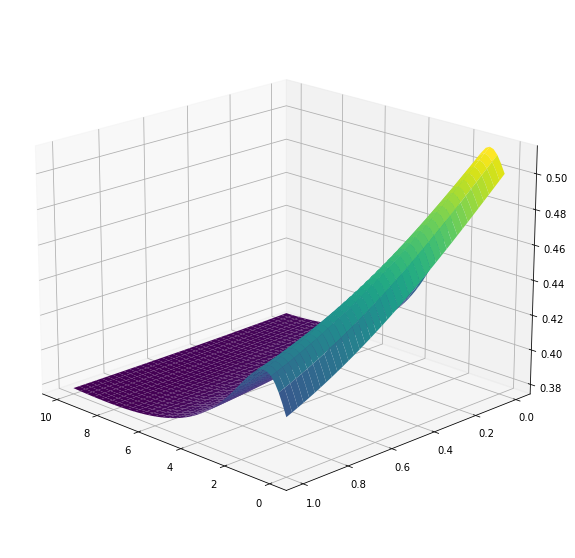

In [39]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs(TX)[:, Eidx]
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)
#print(U)

In [40]:
# Solve with Adam optimizer
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver.solve_with_TFoptimizer(optim, N=2001)
#for i in range(20):
    # WARNING: Update of collocation points currently not supported
    # Vertex values are fixed for coordinates at boundary!
    #X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #solver._updateData(X_r, X_0, X_l, X_u)
    #solver.solve_with_TFoptimizer(optim, N=301)


Start with TF optimizer

 Iter            Loss    Time
-----------------------------
Kirchhoff-Neumann in node  2
incoming edge: 0
incoming edge: 1
outgoing edge: 2
Kirchhoff-Neumann in node  3
incoming edge: 2
outgoing edge: 3
outgoing edge: 4

in node  0 alpha  0.9 beta  0.0
inflow:  0

in node  1 alpha  0.3 beta  0.0
inflow:  1

in node  4 alpha  0.0 beta  0.8
outflow:  3

in node  5 alpha  0.0 beta  0.1
outflow:  4
Tensor("add_9:0", shape=(), dtype=float64)
Tensor("add_14:0", shape=(), dtype=float64)
Tensor("add_20:0", shape=(), dtype=float64)
Tensor("add_31:0", shape=(), dtype=float64)
Tensor("add_45:0", shape=(), dtype=float64)
00000  2.03020215e+00   7.00
00020  3.49908032e-01   23.04
00040  1.53426656e-01   39.29


KeyboardInterrupt: 

In [ ]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 5000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 5000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

In [ ]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
fig = plt.figure(1, figsize=(10, 10))
#fig.canvas.layout.width = '100%'
#fig.canvas.layout.height = '900px'
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
def plot_network(j=0):
    fig = plt.figure(1,clear=True)
    ax = fig.add_subplot(1,1,1, projection='3d')
    t0 = tf.ones_like(xspace)*tspace[j]
    pos = solver.graphPINN.pos
    for i, e in enumerate(solver.graphPINN.E):
        xy = pos[e[0]] + xspace*(pos[e[1]] - pos[e[0]]) / (ub[1]-lb[1])
        #xy = pos[e[0].numpy()] + xspace*(pos[e[1].numpy()] - pos[e[0].numpy()]) 
        #xy = V[e[0].numpy()]+xspace*(V[e[1].numpy()]-V[e[0].numpy()])
        u = solver.graphPINN.NNs(tf.concat([t0,xspace],axis=1))[:, i]
        unum = u.numpy().flatten()
        ax.plot(xy[:,0], xy[:,1], unum)
        #ax.plot(xy[:,0], xy[:,1], unum * (1-unum))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([.0,1.0])
    #ax.set_zlabel('$u_\\theta(x,y)$')
    ax.view_init(12, 135)
    return u

j_slider = widgets.IntSlider(min=0,max=Nt,step=1)
interactive_plot = interactive(plot_network, j=j_slider)
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot
#u = plot_network(4)

Surface plot of function values on a single edge.

In [ ]:
Eidx = 1
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs(TX)[:, Eidx] #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [ ]:
nn=solver.graphPINN.NNs[0]
print(nn.ResNet[0].weights)
print(nn.c.weights)